# <center>**Facial Expression Recognition from Images - Model Training**</center>

This notebook has the purpose of training the transfer learning model on EfficientNet, unfreezing some existing layers.

# **Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import math
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.utils import to_categorical

# **Data preprocessing**

## Loading the csv dataset

In [2]:
# set up of the images path
data_folder = '/Users/marcus/Library/CloudStorage/OneDrive-Personal/Documentos/Loyalist_College/AISC2007/DL Assignment 3/FaceExpressions/'
# data_folder = "C:/Users/edulo/OneDrive/Documentos/Loyalist/Term 3/Deep Learning/Week 11/Assignment/FaceExpressions"
dataset_folder = os.path.join(data_folder, 'dataset/')

In [3]:
# loading the data.csv file containing the images and their labels
data = pd.read_csv(os.path.join(data_folder, 'data.csv'))
data.head()

,Unnamed: 0,path,label
0,0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


The csv file is composed  of a path to the image and its label.

## Analyzing the csv file

In [4]:
# checking the classes of the labels
print(data['label'].unique())

['Surprise' 'Sad' 'Ahegao' 'Happy' 'Neutral' 'Angry']


The dataset is composed of 6 classes. However, Ahegao will not be used in this assignment.

In [5]:
# dropping the Ahegao label
data = data.query('label!= "Ahegao"')
print(data['label'].unique())

['Surprise' 'Sad' 'Happy' 'Neutral' 'Angry']


In [6]:
# checking the data size
data.shape

(14248, 3)

There are 14,248 images in the dataset.

In [7]:
# checking for null values
data.isna().sum()

Unnamed: 0    0
path          0
label         0
dtype: int64

In [8]:
# checking duplicated rows
data.duplicated().sum()

0

No null or duplicated values.

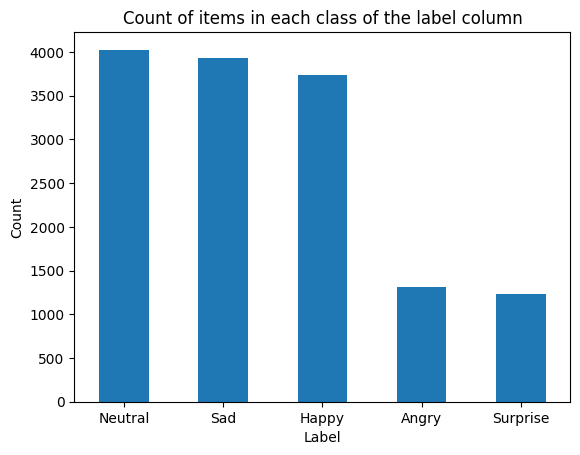

In [9]:
# counting the occurrence of each class
label_count = data['label'].value_counts()

# ploting the counts
label_count.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of items in each class of the label column')
plt.xticks(rotation=0)  # Rotates the labels on the x-axis for better readability
plt.show()

We can see that the Neutral label is the most common class in the dataset (around 4000 occurrences), while the Surprise label is the least common one (around 1250).

Now let's load the images.

## Loading the images

In [10]:
# setting the image size
IMG_SIZE = 224

For example, if IMG_SIZE = 128, then the images will be resized to 128 x 128 pixels.

In [11]:
# function to load the images and their labels
def load_images_and_labels(df):
    images = []
    labels = []
    path = []

    for index, row in tqdm(df.iterrows()):
        # if index == 1500:
        #     break
        # setting the path to the image
        img_path = os.path.join(dataset_folder, row['path'])
        
        # loading the image
        img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE), color_mode='rgb')

        # appending to the lists
        images.append(np.array(img))
        labels.append(row['label'])
        path.append(row['path'])
    return images, labels, path

# loading the images and labels
images, labels, path_full = load_images_and_labels(data)

0it [00:00, ?it/s]

14248it [00:50, 284.64it/s]


In [12]:
# converting lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)
path_full = np.array(path_full)

# printing the size & shape of images and masks and labels
print(" Image Size:", images.shape)
print(" Label Size:", labels.shape)

 Image Size: (14248, 224, 224, 3)
 Label Size: (14248,)


## Visualizing some images

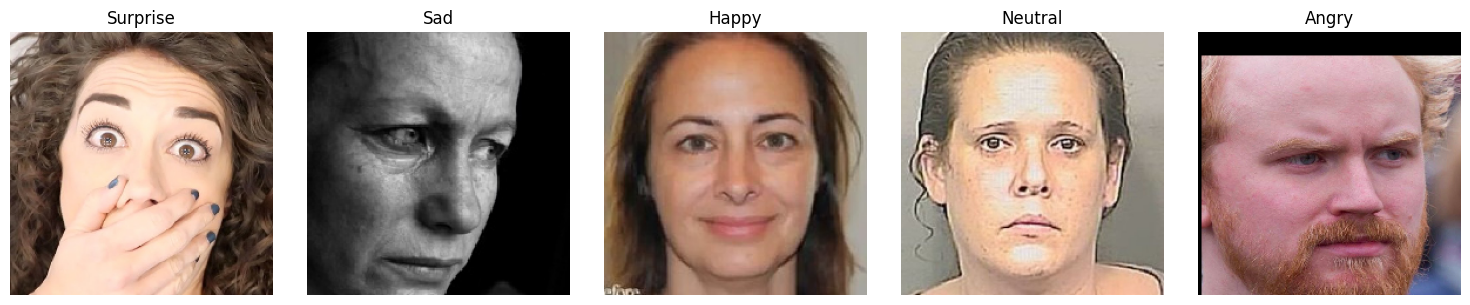

In [13]:
# selecting unique labels and select one image from each of the first 5 classes
classes = ['Surprise', 'Sad', 'Happy', 'Neutral', 'Angry']
selected_images = []
selected_labels = []

for unique_label in classes:  
    for i, label in enumerate(labels):
        if label == unique_label and label not in selected_labels:
            selected_images.append(images[i])
            selected_labels.append(label)
            break

# plotting the selected images
plt.figure(figsize=(15, 3))  
for i, (img, label) in enumerate(zip(selected_images, selected_labels)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f'{label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Building the data set for model training

We will use a pre-defined number of images from each class.

In [14]:
# number of images per class
SAMPLE_SIZE = 1234

In [15]:
X = []
y = []
path = []

# selecting the images from each class
for label in classes:
    # listing indices of images that belong to the current class
    indices = np.where(labels == label)[0]

    # selecting only the first 'SAMPLE_SIZE' images 
    indices = indices[:SAMPLE_SIZE]
    
    # printing the size of the selected images
    print(f'Label: {label}, Size: {len(indices)}')

    # append the images and labels to the dataset lists
    X.extend(images[indices])
    y.extend(labels[indices])
    path.extend(path_full[indices])

# converting lists back to numpy arrays
X = np.array(X)
y = np.array(y)
path = np.array(path)

Label: Surprise, Size: 1234
Label: Sad, Size: 1234
Label: Happy, Size: 1234
Label: Neutral, Size: 1234
Label: Angry, Size: 1234


In [16]:
# Printing the size of each set
print("X shape:", X.shape)
print("y shape:", y.shape)
print("path shape:", path.shape)

X shape: (6170, 224, 224, 3)
y shape: (6170,)
path shape: (6170,)


In [24]:
df = pd.DataFrame(y, path)
df

,0
Surprise/1bd930d6a1c717c11be33db74823f661cb53f86cbba1d3d1f336cdf9~12fffff.jpg,Surprise
Surprise/cropped_emotions.100096~12fffff.png,Surprise
Surprise/0df0e470e33093f5b72a8197fa209d684032cc17f68194e605a26897~12fffff.jpg,Surprise
Surprise/cropped_emotions.260779~12fffff.png,Surprise
Surprise/cropped_emotions.263616~12fffff.png,Surprise
...,...
Angry/cropped_emotions.232268~angry.png,Angry
Angry/cropped_emotions.231576~angry.png,Angry
Angry/cropped_emotions.231473~angry.png,Angry
Angry/cropped_emotions.571381~angry.png,Angry


## Encoding the y dataset

In [25]:
# Encoding the y dataset using one-hot encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert integer labels to one-hot encoded labels
y_one_hot = to_categorical(y_encoded)

print("y_one_hot shape:", y_one_hot.shape)

y_one_hot shape: (6170, 5)


In [41]:
y[0]

'Surprise'

In [38]:
y_encoded[0]

4

In [39]:
print(classes[np.argmax(y_one_hot[0])])

Angry


In [40]:
label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

print(label_mapping)

{0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'Sad', 4: 'Surprise'}


In [98]:
list(label_mapping.values())

['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [42]:
classes

['Surprise', 'Sad', 'Happy', 'Neutral', 'Angry']

In [94]:
len(label_mapping)

5

## Shuffling the datasets

In [43]:
# shuffling the dataset
X_normalized, y_one_hot, path = shuffle(X, y_one_hot, path, random_state=42)

## Spliting data into training and testing

In [44]:
# Split the data into training, validation, and testing sets
X_train_orig, X_temp, y_train_orig, y_temp, path_train, path_temp = train_test_split(X_normalized, y_one_hot, path, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test, path_val, path_test = train_test_split(X_temp, y_temp, path_temp, test_size=0.5, random_state=42)

# Print the sizes of training, validation, and testing sets
print("Training set shape:", X_train_orig.shape[0])
print("Validation set shape:", X_val.shape[0])
print("Testing set shape:", X_test.shape[0])

Training set shape: 3702
Validation set shape: 1234
Testing set shape: 1234


## Data Augmentation

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply augmentation to each image
augmented_images = []
for img in X_train_orig:
    # Apply augmentation
    img_aug = datagen.random_transform(img)
    
    # Append augmented image to list
    augmented_images.append(img_aug)

# Convert list of augmented images to numpy array
augmented_images = np.array(augmented_images)

# Combine original and augmented images
X_train = np.concatenate((X_train_orig, augmented_images), axis=0)
y_train = np.concatenate((y_train_orig, y_train_orig), axis=0)

In [22]:
# Print the total number of images after augmentation
print("Shape of X_train after augmentation:", X_train.shape[0])

Shape of X_train after augmentation: 7404


In [23]:
del images, labels

# **Helper functions**

They will be used to plot the results and performance evaluation.

In [24]:
# function to plot the loss and accuracy of the NN
def plot_history(history):
    # accessing the training and validation accuracy values
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    x = [i for i in range (1, len(train_accuracy) + 1)]

    # creating two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # plotting the lines on the first subplot
    ax1.plot(x, train_loss, label='train_loss')
    ax1.plot(x, val_loss, label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()

    # plotting the lines on the second subplot
    ax2.plot(x, train_accuracy, label='train_accuracy')
    ax2.plot(x, val_accuracy, label='val_accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [25]:
# function that calculates performance metrics
def performance(model, x_val, y_val, classes):
    # geting model predictions
    y_pred_prob = model.predict(x_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_val_integers = np.argmax(y_val, axis=1)

    accuracy = accuracy_score(y_val_integers, y_pred)
    print(f'\nAccuracy: {accuracy}')

    class_report = classification_report(y_val_integers, y_pred, target_names=classes)
    print('\nClassification Report:\n', class_report)

    # Binarize y_val for AUC calculation
    y_val_binarized = label_binarize(y_val_integers, classes=[i for i in range(len(classes))])

    # Calculate AUC for each class and take the average
    auc_score = roc_auc_score(y_val_binarized, y_pred_prob, multi_class='ovr')
    print(f'Average AUC: {auc_score}')
    print()
    
    conf_matrix = confusion_matrix(y_val_integers, y_pred)
    # print('Confusion Matrix:\n', conf_matrix)
    # print()

    # Computing ROC curve and ROC area for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting Confusion Matrix and ROC curve
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Confusion Matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')

    # ROC Curve
    colors = ['blue', 'red', 'green', 'orange', 'black']
    for i, color in zip(range(len(classes)), colors):
        ax[1].plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))

    ax[1].plot([0, 1], [0, 1], 'k--', lw=2)
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic (ROC)')
    ax[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# **Modelling**
Building a transfer learnt model from EfficientNet by unfreezing some existing layers. Reference: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

During training, we noticed that the model has a strong tendency of overfitting. These were the actions we took tominimize it:
- Increased the number of training images by applying data augmentation.
- Ensured model simplicity by not adding Dense layers at the end of the model, before the output layer.
- Decreased the batch size to 16.
- Applyed Early Stopping and Learning Rate Scheduler.
- Applyed Dropout and L2 regularization.
- Unfroze more layers.

## Creating the model

In [26]:
# loading the pre-trained EfficientNet model
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = False

# adding the custom classification head
x = GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.4, name="top_dropout")(x)
outputs = Dense(len(classes), activation="softmax", name="pred", kernel_regularizer=l2(0.01))(x)

# combining the base model and custom head
model = Model(inputs, outputs, name="EfficientNet_FaceExpressions")

2024-04-07 20:34:03.317918: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-07 20:34:03.317966: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-07 20:34:03.317977: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-07 20:34:03.318011: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-07 20:34:03.318025: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [27]:
print("Number of layers in the base model: ", len(base_model.layers))
print("Number of layers in the final model: ", len(model.layers))

Number of layers in the base model:  238
Number of layers in the final model:  242


## Unfreezing layers and compiling the model

In [28]:
def unfreeze_model(model):
    # We unfreeze the top 50 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-50:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    model.compile(
        optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)

In [29]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# printing model summary
model.summary()

Model: "EfficientNet_FaceExpressions"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,061,096 (15.49 MB)

 Trainable params: 2,296,469 (8.76 MB)

 Non-trainable params: 1,764,627 (6.73 MB)

## Early stopping and Learning Rate Scheduler

To help preventing overfitting and to recover the best weights.

In [31]:
# defining the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [32]:
# function for step decay schedule.
def step_decay(epoch):
    initial_lr = 1e-3  # starting learning rate
    drop = 0.5  # factor by which to drop the LR
    epochs_drop = 5.0  # drop the LR every 'epochs_drop' epochs
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

lr_scheduler = LearningRateScheduler(step_decay)

## Training the model

In [33]:
# Train the model
start_time = time.time()

history = model.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])

end_time = time.time()
execution_time = end_time - start_time
print(f"\nTotal Execution Time: {execution_time} seconds")

Epoch 1/30


2024-04-07 20:34:09.758792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


463/463 ━━━━━━━━━━━━━━━━━━━━ 64s 114ms/step - accuracy: 0.3662 - loss: 1.8385 - val_accuracy: 0.4797 - val_loss: 1.6511 - learning_rate: 0.0010
Epoch 2/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 43s 94ms/step - accuracy: 0.5846 - loss: 1.1653 - val_accuracy: 0.5940 - val_loss: 1.2753 - learning_rate: 0.0010
Epoch 3/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 43s 93ms/step - accuracy: 0.6762 - loss: 0.9289 - val_accuracy: 0.7423 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 4/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.7238 - loss: 0.7642 - val_accuracy: 0.6961 - val_loss: 0.8033 - learning_rate: 0.0010
Epoch 5/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 43s 93ms/step - accuracy: 0.7957 - loss: 0.5920 - val_accuracy: 0.7593 - val_loss: 0.6110 - learning_rate: 5.0000e-04
Epoch 6/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.8435 - loss: 0.4437 - val_accuracy: 0.7593 - val_loss: 0.7095 - learning_rate: 5.0000e-04
Epoch 7/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 43s 93ms/step - accuracy: 0.8604 - los

## Training evaluation

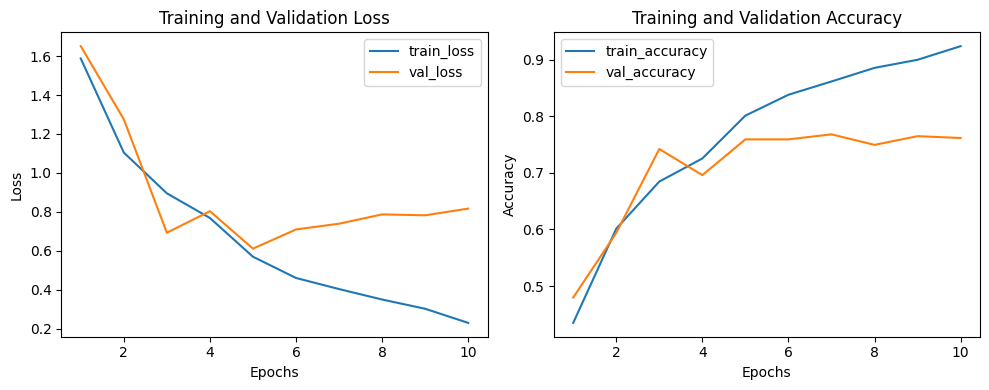

In [34]:
plot_history(history)

The validations accuracy reached 0.92, but the validation accuracy reached only a maximum of 0.7836, indicatting overfitting.

## Performance evaluation - train dataset

232/232 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step

Accuracy: 0.9639384116693679

Classification Report:
               precision    recall  f1-score   support

    Surprise       0.98      0.97      0.98      1510
         Sad       0.99      0.99      0.99      1466
       Happy       0.90      0.97      0.93      1504
     Neutral       0.98      0.92      0.95      1486
       Angry       0.99      0.96      0.98      1438

    accuracy                           0.96      7404
   macro avg       0.97      0.96      0.96      7404
weighted avg       0.97      0.96      0.96      7404

Average AUC: 0.998614241288343



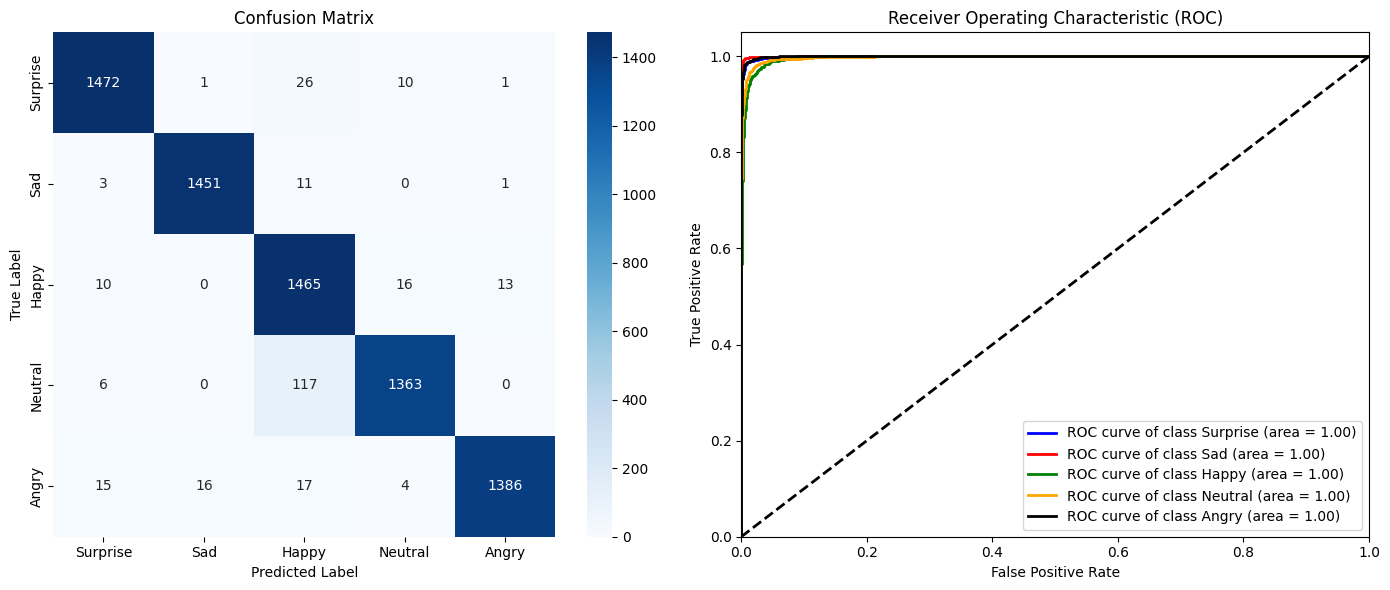

In [35]:
performance(model, X_train, y_train, classes)

We were able to get good F1-scores for all classes, but 'Happy' and 'Neutral' have the lowest performances.

## Performance evaluation - validation dataset

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step

Accuracy: 0.7682333873581848

Classification Report:
               precision    recall  f1-score   support

    Surprise       0.78      0.79      0.79       247
         Sad       0.91      0.87      0.89       246
       Happy       0.57      0.81      0.67       233
     Neutral       0.73      0.57      0.64       251
       Angry       0.92      0.81      0.86       257

    accuracy                           0.77      1234
   macro avg       0.78      0.77      0.77      1234
weighted avg       0.79      0.77      0.77      1234

Average AUC: 0.945630511039653



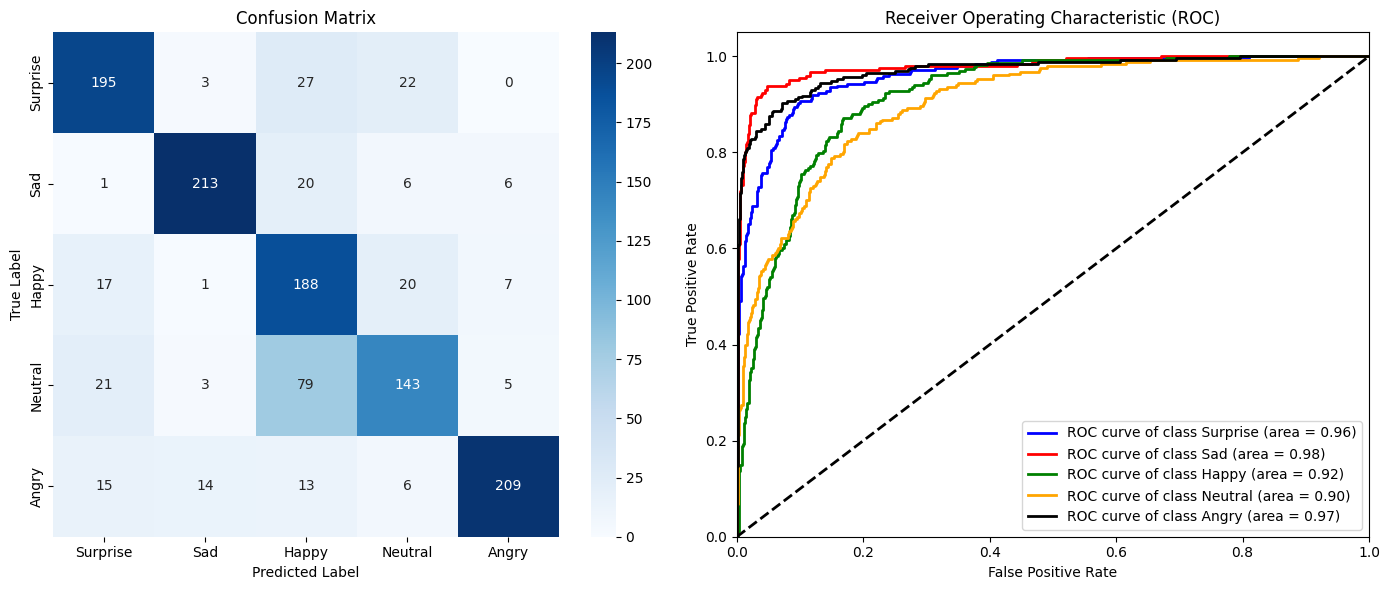

In [36]:
performance(model, X_val, y_val, classes)

The F1-score has a similar pattern compared to the train dataset, but with lower values.

## Performance evaluation - test dataset

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step

Accuracy: 0.766612641815235

Classification Report:
               precision    recall  f1-score   support

    Surprise       0.76      0.80      0.78       232
         Sad       0.91      0.83      0.87       255
       Happy       0.59      0.78      0.67       249
     Neutral       0.72      0.60      0.65       240
       Angry       0.92      0.81      0.86       258

    accuracy                           0.77      1234
   macro avg       0.78      0.77      0.77      1234
weighted avg       0.78      0.77      0.77      1234

Average AUC: 0.9417493302667174



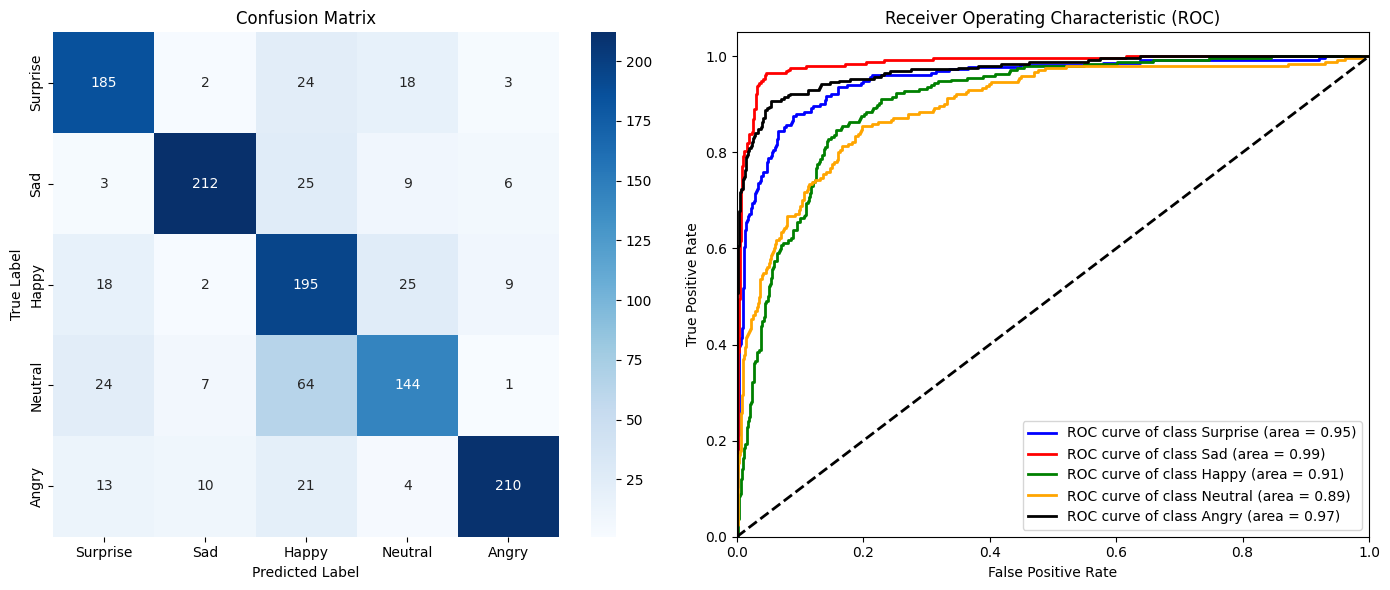

In [37]:
performance(model, X_test, y_test, classes)

The performance with the test datasets follows closelly the one from the validation set, but slightly inferior.

## Model saving

In [38]:
# naming the model
model_name = "efficientnet_model_test.h5"

# path to the 'models' directory where the model will be saved
models_dir = os.path.join(os.getcwd(), 'models')

# full path for the model file
model_path = os.path.join(models_dir, model_name)

# saving the model
model.save(model_path)

In [48]:
from tensorflow.keras.models import load_model
model_path = './models/efficientnet_model_0766.h5'
model = load_model(model_path)

2024-04-07 22:29:40.984281: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-07 22:29:40.984346: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-07 22:29:40.984361: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-07 22:29:40.984426: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-07 22:29:40.984638: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [41]:
path_test

array(['Sad/6d6f256f0392cb3f99aefe637b0d73c172c69e374146833e8c4e6954.jpg',
       'Sad/3abb637325b1a4f962bf690bc92aa997d0cf95fe6f4c4c23491dc6e1.jpg',
       'Surprise/cropped_emotions.261479~12fffff.png', ...,
       'Angry/cropped_emotions.571297~angry.png',
       'Surprise/cropped_emotions.260193~12fffff.png',
       'Neutral/cropped_emotions.278124f.png'], dtype='<U78')

In [43]:
count = 0

x = 0
for i in path_test:
    x += 0
    if x == 10:
        break
    expression = i.split("/")[0]
    # print(i)
    img = image.load_img(dataset_folder + '/' + i, target_size=(IMG_SIZE,IMG_SIZE), color_mode='rgb')

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    prediction = model.predict(img_array)  # making the prediction
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    # print(predicted_class, classes[predicted_class], expression)

    if classes[predicted_class] == expression:
        count += 1

print(100*count/len(path_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

In [49]:
X_test.shape

(1234, 224, 224, 3)

In [90]:
import random

i = random.randint(0, SAMPLE_SIZE - 1)
print(i)

754


In [91]:
img_sample = path_test[i]

In [92]:
img = image.load_img(dataset_folder + '/' + img_sample, target_size=(IMG_SIZE,IMG_SIZE), color_mode='rgb')

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
prediction = model.predict(img_array)  # making the prediction
predicted_class = np.argmax(prediction)
confidence = np.max(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [93]:
print('Model prediction:', label_mapping[predicted_class])
print('y_test label:', label_mapping[np.argmax(y_test[i])])
print('Expected result (folder):', img_sample.split("/")[0])

Model prediction: Surprise
y_test label: Surprise
Expected result (folder): Surprise


classes = ['Surprise', 'Sad', 'Happy', 'Neutral', 'Angry']